In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import PIL
from IPython.display import HTML

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE= 32
#IMAGE_SIZE2 = 640
CHANNELS = 3
epochs=30

In [4]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/wheat plant /CNN/trai",
    seed=123,
    shuffle=True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 1402 files belonging to 5 classes.


In [5]:
class_names= dataset.class_names
class_names

['Brown_rust', 'Healthy', 'Yellow_rust', 'stem_rust', 'wheat-septoria']

In [6]:
len(dataset)


44

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 2 2 2 2 2 2 1 1 1 3 2 0 2 0 0 1 1 0 0 0 2 4 0 0 2 2 0 2 1 0]


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[1].shape)

(256, 256, 3)


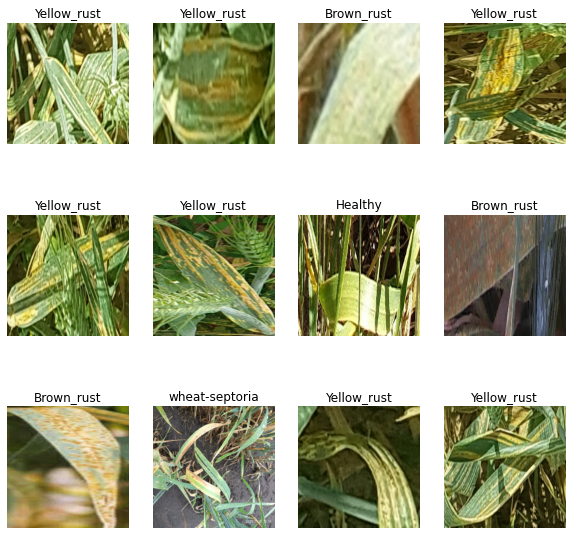

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
   # print(image_batch[0].shape

In [10]:
len(dataset)

44

In [11]:
train_size = 0.8
len(dataset)*train_size

35.2

In [12]:
train_ds =dataset.take(6)
len(train_ds)


6

In [13]:
test_ds =dataset.skip(10)
len(test_ds)

34

In [14]:
val_size=0.1
len(dataset)*val_size

4.4

In [15]:
val_ds =test_ds.take(4)
len(val_ds)

4

In [16]:
test_ds =test_ds.skip(4)
len(test_ds)

30

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=500):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [19]:
len(train_ds)

35

In [20]:
len(val_ds)

4

In [21]:
len(test_ds)

5

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])


In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [26]:
input_shape =(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5
model =models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)



In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/30
35/35 [==============================] - 140s 434ms/step - loss: 1.3421 - accuracy: 0.4156 - val_loss: 1.1836 - val_accuracy: 0.4609
Epoch 2/30
35/35 [==============================] - 9s 246ms/step - loss: 1.0311 - accuracy: 0.5996 - val_loss: 1.0036 - val_accuracy: 0.6875
Epoch 3/30
35/35 [==============================] - 9s 262ms/step - loss: 0.9573 - accuracy: 0.5969 - val_loss: 1.0856 - val_accuracy: 0.6484
Epoch 4/30
35/35 [==============================] - 9s 249ms/step - loss: 0.8379 - accuracy: 0.7002 - val_loss: 0.8244 - val_accuracy: 0.7422
Epoch 5/30
35/35 [==============================] - 9s 242ms/step - loss: 0.7015 - accuracy: 0.7639 - val_loss: 0.9780 - val_accuracy: 0.7734
Epoch 6/30
35/35 [==============================] - 9s 261ms/step - loss: 0.6298 - accuracy: 0.8025 - val_loss: 0.7630 - val_accuracy: 0.7734
Epoch 7/30
35/35 [==============================] - 9s 261ms/step - loss: 0.6150 - accuracy: 0.8070 - val_loss: 0.7075 - val_accuracy: 0.7812
Epoc

In [30]:
scores = model.evaluate(test_ds)


5/5 [==============================] - 6s 36ms/step - loss: 0.3015 - accuracy: 0.9187


In [31]:
scores

[0.3014814555644989, 0.918749988079071]

In [32]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.342143177986145,
 1.031062126159668,
 0.9573405981063843,
 0.8378869891166687,
 0.701488196849823]

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

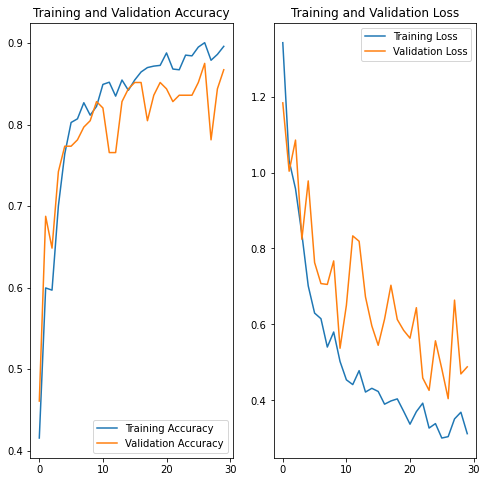

In [35]:


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
history

first image to predict
actual label: Brown_rust
1/1 [==============================] - 0s 139ms/step
predicted label: Brown_rust


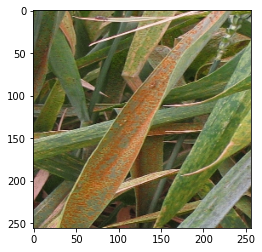

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[2])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


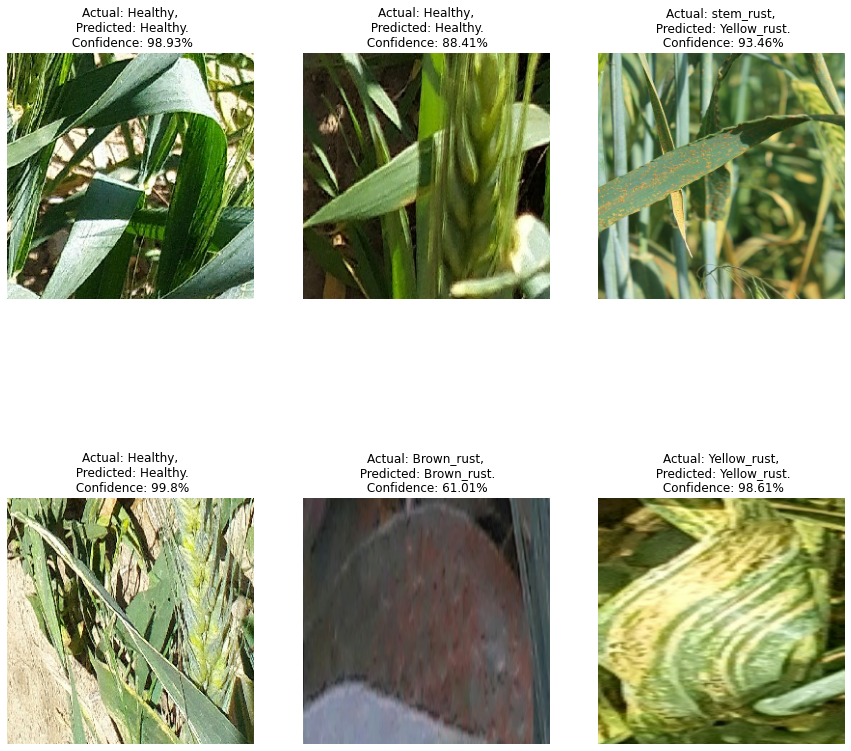

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [41]:
'''import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/wheat plant /CNN/models") + [0]])+1
model.save(f"/content/drive/MyDrive/wheat plant /CNN/models/{model_version}")
'''

'import os\nmodel_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/wheat plant /CNN/models") + [0]])+1\nmodel.save(f"/content/drive/MyDrive/wheat plant /CNN/models/{model_version}")\n'

In [42]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.2/214.2 KB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [55]:
import os
# create a directory to store the model files
os.mkdir('tfjs-dir')

# convert to Tensorflow.js
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'content/drive/MyDrive/wheat plant /CNN/tfjs-dir')

FileExistsError: ignored

In [52]:
# check the the directory containing the model is available
!ls

drive  sample_data  tfjs-dir  tfjs_dir


In [53]:
# view the files that make up the tensorflow.js model
os.listdir('tfjs_dir')

['model.json', 'group1-shard1of1.bin']

In [48]:
# Delete the image data directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

shutil.rmtree('base_dir')

NameError: ignored